# Homework 2: Graph Mining
*Due Wednesday November 14th, 2018 at 11:59 pm*

*Notebook Author: Koki Sasagawa*

Mining a large social network to uncover how well homophily can predict identity as well as the network structure. 

**Task2:** Attribute Prediction - most of the nodes in the social network are provided with one or more attributes that can be drawn from different types. (e.g., age, occupation, musical preference, etc. ) Predict the probabilities of attributes for a set of completely unlabeled nodes

## Data

1. `labeled-vertices.train.tsv` & `labeled-vertices.dev.tsv` & `unlabeled-verticies.test.tsv` 
   - users with attributes formatted as the following: 

   > - **vertex1** T1:3 T7:1 T4:2
   > - **vertex2** T2:4
   > - **vertex3** T4:3 T3:1
   
   - Each value is specified as `AttributeType:Value`
   - Not every user will have their attributes listed 
   - Majority users should have at least 2 attribute set
2. `unlabeled-verticies.test.txt` - simply have list of vertices that should predict attributes and their values 

## Submission 

**Attribute prediction** should be a csv file with two columns: id and attr. 
The attr column should contain a space-deliminted list of the attributes you think the user with that id has. The file should have the following structure:

> id, attr
> 
> 123, T0:0 T1:1 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import time
# import os
# from pprint import pprint

## 1. Create Graph

In [2]:
print("Creating network graph...")
start_time = time.time() 

with open("../data/network.tsv", 'rb') as f:
    grph = nx.read_edgelist(path=f, delimiter='\t', encoding='utf8')

end_time = time.time()
print("Network graph created. Process took {:.04f} seconds".format(end_time - start_time))

# Check that graph is of correct size
print("Number of edges: {}".format(grph.number_of_edges())) # There should be 30915267
print("Number of nodes: {}".format(grph.number_of_nodes())) # There should be 6626753

Creating network graph...
Network graph created. Process took 261.4865 seconds
Number of edges: 30915267
Number of nodes: 6626753


## 2. Load all files for attribute prediction 

In [3]:
print("Reading in dev set...")
start_time = time.time()

dev_set_chunks = pd.read_csv("../data2/labeled-vertices.dev.tsv",
                      delimiter='\t',
                      usecols=[0,1],
                      names=['id', 'attr'],
                      header=None,
                      chunksize=100000)

dev_set = pd.concat(dev_set_chunks)

# Free memory 
dev_set_chunks = None

# with open('../data2/labeled-vertices.dev.test.tsv') as f:
#     for line in f:
#         dev_set.append(line.rstrip())

end_time = time.time()
print("Dev set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
dev_set.head()

Reading in dev set...
Dev set loaded. Process took 0.3278 seconds


id          attr
0  2666403    T0:2 T1:99
1  2627940    T0:0 T1:26
2  4843136    T0:0 T1:26
3  5396835  T0:0 T1:1813
4  5438188  T0:1 T1:1733

In [19]:
print("Reading in training set...")
start_time = time.time()

train_set_chunks = pd.read_csv("../data2/labeled-vertices.train.tsv",
                      delimiter='\t',
                      usecols=[0,1],
                      names=['id', 'attr'],
                      header=None,
                      chunksize=100000)

train_set = pd.concat(train_set_chunks)

# Free memory 
train_set_chunks = None

# with open('../data2/labeled-vertices.dev.test.tsv') as f:
#     for line in f:
#         dev_set.append(line.rstrip())

end_time = time.time()
print("Train set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
print(train_set.shape[0])
train_set.head()

Reading in training set...
Train set loaded. Process took 2.0714 seconds
5301403


id       attr
0  5509623  T0:0 T1:0
1  6334893  T0:0 T1:1
2  1218900  T0:1 T1:2
3  3871398  T0:1 T1:2
4  3942361  T0:0 T1:3

In [4]:
print('Reading in test set...')
start_time = time.time()

test_set = []

with open('../data2/unlabeled-vertices.test.txt') as f:
    for line in f:
        test_set.append(line.rstrip())

end_time = time.time()
print("Test set loaded. Process took {:.04f} seconds".format(end_time - start_time))

# Check 
test_set[:5]

Reading in test set...
Test set loaded. Process took 0.2285 seconds


['4546232', '3711008', '6394112', '5883774', '2843733']

## 3. Define the functions for attribute prediction

The following function will compute some similarity metric on the neighbors of a node, and the node will inherit the attributes of the highest scoring node. A jaccard function that perform dfs for a specified number of steps has been defined, but is commented out by default due to being computationally expensive to run on some machines. 

In [7]:
def highest_jaccard_similarity(test_set, grph):
    '''Calculate then jaccard similarity of neighbors and return the most similar node
    
    If jaccard similarity of two nodes is zero, return 0 
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list
    :params grph: network containing target nodes
    :type grph: networkx graph
    :return: node and the most similar neighboring node
    :rtype: dict
    '''
    
    # Store results
    sim_results = {}
    
    count = 0 
    
    for i in test_set:         
        nearest_neighbors = list(grph.neighbors(i))
        # If a node only has only 1 neighbor, inherit that neighbors attributes 
        if len(nearest_neighbors) == 1: 
            sim_results[i] = nearest_neighbors[0]
        else:
            # Generate node-neighbor pairings 
            node_pairs = [(i, j) for j in nearest_neighbors]
            preds = nx.jaccard_coefficient(grph, ebunch=node_pairs)

            # Sort by similarity score
            preds = list(preds)
            preds.sort(key=lambda x: x[2], reverse=True)

            # Take the node with highest sim score
            # If similarity is 0, return 0
            if preds[0][2] == 0.0:
                sim_results[i] = 0
            else:
                sim_results[i] = preds[0][1]

    return sim_results

In [8]:
# def highest_jaccard_similarity(test_set, grph, depth):
#     '''Calculate then jaccard similarity of neighbors and return the most similar node
    
#     Specify the number of steps away from the source node to compare 
    
#     :params test_set: target nodes we want to find the most similar neighbor for
#     :type test_set: list
#     :params grph: network containing target nodes
#     :type grph: networkx graph
#     :params depth: number of steps away from source node
#     :type depth: int 
#     :return: node and the most similar neighboring node
#     :rtype: dict
#     '''
    
#     # Store results
#     sim_results = {}
    
#     for i in test_set:
#         # Depth-first search over the nodes
#         sub_g = nx.dfs_edges(grph, source=i, depth_limit=depth)
        
#         # generate node pairs to compare source node with nodes 2 step away
#         node_pairs = [(i, x[1]) for x in sub_g]

#         preds = nx.jaccard_coefficient(grph, ebunch=node_pairs)

#         # Sort by similarity score
#         preds = list(preds)
#         preds.sort(key=lambda x: x[2], reverse=True)

#         # Take the node with highest sim score
#         # If similarity is 0, return 0
#         if preds[0][2] == 0.0:
#             sim_results[i] = 0
#         else:
#             sim_results[i] = preds[0][1]

#     return sim_results

In [9]:
def highest_adamic_adar_similarity(test_set, grph):
    '''Calculate then adamic/adar similarity of neighbors and return the most similar node
    
    If adamic/adar similarity of two nodes is zero, return 0
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list 
    :params grph: network containing target nodes
    :type grph: networkx graph
    :return: node and the most similar neighboring node
    :rtype: dict
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # If a node only has only 1 neighbor, inherit that neighbors attributes 
        if len(nearest_neighbors) == 1: 
            sim_results[i] = nearest_neighbors[0]
        else:
            # Generate node-neighbor pairings 
            node_pairs = [(i, j) for j in nearest_neighbors]
            preds = nx.adamic_adar_index(grph, ebunch=node_pairs)

            # Sort by similarity score
            preds = list(preds)
            preds.sort(key=lambda x: x[2], reverse=True)

            # Take the node with highest sim score
            # If similarity is 0, return 0
            if preds[0][2] == 0.0:
                sim_results[i] = 0
            else:
                sim_results[i] = preds[0][1]

    return sim_results

In [10]:
def highest_preferential_attachment_score(test_set, grph):
    '''Calculate then preferential attachment scores of neighbors and return the highest scoring node
    
    :params test_set: target nodes we want to find the most similar neighbor for
    :type test_set: list
    :params grph: network containing target nodes
    :type grph: networkx graph
    :return: node and the most similar neighboring node
    :rtype: dict
    '''
    
    # Store results
    sim_results = {}
    
    for i in test_set:
        nearest_neighbors = list(grph.neighbors(i))
        # If a node only has only 1 neighbor, inherit that neighbors attributes 
        if len(nearest_neighbors) == 1: 
            sim_results[i] = nearest_neighbors[0]
        else:
            # Generate node-neighbor pairings 
            node_pairs = [(i, j) for j in nearest_neighbors]
            preds = nx.preferential_attachment(grph, ebunch=node_pairs)

            # Sort by score
            preds = list(preds)
            preds.sort(key=lambda x: x[2], reverse=True)

            # Take the node with highest score
            # If score is 0, return 0
            if preds[0][2] == 0.0:
                sim_results[i] = 0
            else:
                sim_results[i] = preds[0][1]

    return sim_results

## 4. Generate node pairs

Jaccard similarity and Adamic/Adar similarity both require nodes to have common neighbors, or the similarity score will be zero. Preferential attachment, however, can still be calculated as it is based on the idea that nodes will attach to nodes of higher degree. For nodes where Jaccard and Adamic/Adar failed to produce a similarity score, use the node suggested by rules of preferential attachment. 

In [89]:
print('Running jaccard similarity...')
start_time = time.time()

jaccard_similarity_nodes = highest_jaccard_similarity(test_set, grph)

# After uncommenting the function, uncomment the line below to run jaccard similarity calculations
# on nodes 2 steps away from the target node. 
# jaccard_similarity_nodes = highest_jaccard_similarity(test_set, grph, 2)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running jaccard similarity...
Node pairs generated. Process took 31.7548 seconds


In [135]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 18.4766 seconds


In [136]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(test_set, grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 2.4830 seconds


## 5. Select between Jaccard similarity or Adamic/Adar node pairs for attribute predictions 

In [109]:
# # Predictions with Jaccard

# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values())
#                         })

In [121]:
# # Predictions with Jaccard + preferential attachment

# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'jaccard_similarity': list(jaccard_similarity_nodes.values()), 
#                         'preferential_attachment': list(preferential_attachment_nodes.values()),
#                         })

In [91]:
# # Predictions with Adamic/Adar

# predictions = pd.DataFrame({
#                         'id': test_set,
#                         'adamic_adar': list(adamic_adar_nodes.values())
#                         })

In [137]:
# Predictions with Adamic/Adar + preferential attachment

predictions = pd.DataFrame({
                        'id': test_set,
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

In [138]:
predictions.head()

id adamic_adar preferential_attachment
0  4546232     2494614                 2494614
1  3711008     2444912                 2174169
2  6394112     6223074                 6223074
3  5883774     4485305                 4485305
4  2843733     3931905                 3931905

### Use Predictions just from Jacccard or Adamic/Adar

In [139]:
# # Rename column name 
# predictions.columns = ['id','attr']

### Use Predictions from Jaccard and preferential attachment

In [123]:
# # Find the number of cells where jaccard similarity did not return a similarity score and returned 0
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['jaccard_similarity'])))

Number of 0's: 58932


In [124]:
# # For every row where jaccard similarity failed to return a candidate node due to lack of common neighbors,
# # use the node returned by preferential attachment
# predictions['attr'] = np.where(predictions['jaccard_similarity'] == 0, predictions['preferential_attachment'], predictions['jaccard_similarity'])

In [125]:
# print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

Number of 0's: 0


In [140]:
# # We no longer need columns jaccard_similarity and preferential attachment, so drop them
# predictions.drop(['jaccard_similarity', 'preferential_attachment'], axis=1, inplace=True)

### Use Predictions from Adamic/Adar and preferential attachment

In [141]:
# Find the number of cells where jaccard similarity did not return a similarity score and returned 0
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 58932


In [142]:
# For every row where jaccard similarity failed to return a candidate node due to lack of common neighbors,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])

In [143]:
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

Number of 0's: 0


In [144]:
# We no longer need columns jaccard_similarity and preferential attachment, so drop them
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

## 6. Obtain attributes for nodes

In [24]:
print("There are {} rows in the prediction dataframe".format(predictions.shape[0]))
predictions.head()

There are 662675 rows in the prediction dataframe


id     attr
0  2666403  2051632
1  2627940  4843136
2  4843136  2627940
3  5396835  2352112
4  5438188  5690565

In [146]:
# Variable type in train_set 
print(type(train_set['id'][0]))

<class 'numpy.int64'>


In [147]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with train_set
print(type(predictions['attr'][0]))

predictions = predictions.astype(dtype=np.int64, copy=True)
print(type(predictions['attr'][0]))

<class 'str'>
<class 'numpy.int64'>


In [148]:
# Merge preditions dataframe with trainset by id 
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')
# Check results
results.head()

id_x   attr_x       id_y             attr_y
0  4546232  2494614  2494614.0       T0:0 T1:1766
1  3711008  2444912  2444912.0       T0:0 T1:1762
2  6394112  6223074  6223074.0  T0:0 T1:1914 T8:0
3  5883774  4485305  4485305.0        T0:0 T1:944
4  2843733  3931905  3931905.0        T0:0 T1:538

In [149]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

In [150]:
# Rename columns
results.columns = ['id', 'attr']

# Show results
results.head()

id               attr
0  4546232       T0:0 T1:1766
1  3711008       T0:0 T1:1762
2  6394112  T0:0 T1:1914 T8:0
3  5883774        T0:0 T1:944
4  2843733        T0:0 T1:538

In [151]:
# Check results
print('Results contain {} nodes'.format(results.shape[0]))

Results contain 662675 nodes


## 7. Save attribute predictions as csv file

In [152]:
# Save Results
results.to_csv('../data2/attribute_predictions_Adamic_PA.csv', index=False)
print('*****Done*****')

*****Done*****


## 8. Development Testing

Run against the golden standard to measure algorithm preformance.

In [20]:
# Change id's to str type
dev_set['id'] = dev_set['id'].astype(str)

In [21]:
print('Running preferential attachment...')
start_time = time.time()

preferential_attachment_nodes = highest_preferential_attachment_score(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running preferential attachment...
Node pairs generated. Process took 12.1731 seconds


In [22]:
print('Running adamic/adar similarity...')
start_time = time.time()

adamic_adar_nodes = highest_adamic_adar_similarity(dev_set['id'], grph)

end_time = time.time()
print("Node pairs generated. Process took {:.04f} seconds".format(end_time - start_time))

Running adamic/adar similarity...
Node pairs generated. Process took 10.9525 seconds


In [25]:
# Predictions with Adamic/Adar + preferential attachment

predictions = pd.DataFrame({
                        'id': dev_set['id'],
                        'adamic_adar': list(adamic_adar_nodes.values()), 
                        'preferential_attachment': list(preferential_attachment_nodes.values()),
                        })

In [26]:
# Find the number of cells where jaccard similarity did not return a similarity score and returned 0
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['adamic_adar'])))

Number of 0's: 140181


In [27]:
# For every row where jaccard similarity failed to return a candidate node due to lack of common neighbors,
# use the node returned by preferential attachment
predictions['attr'] = np.where(predictions['adamic_adar'] == 0, predictions['preferential_attachment'], predictions['adamic_adar'])

In [28]:
print("Number of 0\'s: {}".format(predictions.shape[0] - np.count_nonzero(predictions['attr'])))

Number of 0's: 0


In [29]:
# We no longer need columns jaccard_similarity and preferential attachment, so drop them
predictions.drop(['adamic_adar', 'preferential_attachment'], axis=1, inplace=True)

In [30]:
print('Predictions table have {} rows'.format(predictions.shape[0]))
predictions.head()

Predictions table have 662675 rows


id     attr
0  2666403  2051632
1  2627940  4843136
2  4843136  2627940
3  5396835  2352112
4  5438188  5690565

In [31]:
# The values in the prediction dataframe are currently str type
# convert them to int64 to allow merge with train_set
print(type(predictions['attr'][0]))

predictions = predictions.astype(dtype=np.int64, copy=True)
print(type(predictions['attr'][0]))

<class 'str'>
<class 'numpy.int64'>


In [32]:
# Merge preditions dataframe with trainset by id 
results = predictions.merge(train_set, left_on='attr', right_on='id', how='left')
# Check results
print('Results table has {} rows'.format(results.shape[0]))
results.head()

Results table has 662675 rows


id_x   attr_x       id_y        attr_y
0  2666403  2051632  2051632.0    T0:2 T1:99
1  2627940  4843136        NaN           NaN
2  4843136  2627940        NaN           NaN
3  5396835  2352112  2352112.0  T0:0 T1:1813
4  5438188  5690565  5690565.0  T0:1 T1:1733

In [33]:
# Drop unecessary columns
results.drop(['attr_x', 'id_y'], inplace=True, axis=1)

# Rename columns
results.columns = ['id', 'attr']

# Show results
results.head()

id          attr
0  2666403    T0:2 T1:99
1  2627940           NaN
2  4843136           NaN
3  5396835  T0:0 T1:1813
4  5438188  T0:1 T1:1733

In [37]:
results['id'] = results['id'].astype(np.int64)
dev_set['id'] = results['id'].astype(np.int64)

In [38]:
# Perform a merge with indicator on
dev_results = dev_set.merge(results, left_on='id', right_on='id')

# Check that results were produced
dev_results.head()

id        attr_x        attr_y
0  2666403    T0:2 T1:99    T0:2 T1:99
1  2627940    T0:0 T1:26           NaN
2  4843136    T0:0 T1:26           NaN
3  5396835  T0:0 T1:1813  T0:0 T1:1813
4  5438188  T0:1 T1:1733  T0:1 T1:1733

In [40]:
dev_results = dev_results[['id', 'attr_x', 'attr_y']].assign(NE=dev_results['attr_x'] == dev_results['attr_y'])

In [41]:
dev_results.head()

id        attr_x        attr_y     NE
0  2666403    T0:2 T1:99    T0:2 T1:99   True
1  2627940    T0:0 T1:26           NaN  False
2  4843136    T0:0 T1:26           NaN  False
3  5396835  T0:0 T1:1813  T0:0 T1:1813   True
4  5438188  T0:1 T1:1733  T0:1 T1:1733   True

In [42]:
# Total number of True and False Predictions 
dev_results['NE'].value_counts()

True     390889
False    271786
Name: NE, dtype: int64

In [92]:
# Calculate the average degree of the nodes for the top 10 most missed attributes 
count = 0
total_number_of_nodes = 0

# Create list of attributes and the average of the degree of these nodes to graph later
all_attributes = []
ave_degree_by_attribute = []

# Most missed attributes and corresponding number of nodes, sorted from greatest to least
for k, v in dict(dev_results[dev_results['NE'] == False]['attr_x'].value_counts()).items():
    list_of_degrees = []
    if count < 50:
        # Store attribute names
        all_attributes.append(k)
        
        # Get all nodes of particular attribute
        missed_nodes = dev_results[dev_results['attr_x'] == str(k)]['id']
        
        for i in missed_nodes: 
            list_of_degrees.append(grph.degree[str(i)])
            ave_degree = np.mean(list_of_degrees)

#            #Only use for node count less than 50 
#         print('There are {} nodes with attribute {}'.format(v, k))
#         print("The Average degree of these nodes is: {}".format(ave_degree))
        
        # Store ave degree 
        ave_degree_by_attribute.append(ave_degree)
        
        total_number_of_nodes += v
        count += 1 

print("The top {} missed attributes make up {} of all missed attributes.".format(count, total_number_of_nodes / 271786))

The top 50 missed attributes make up 0.24492063608868742 of all missed attributes.


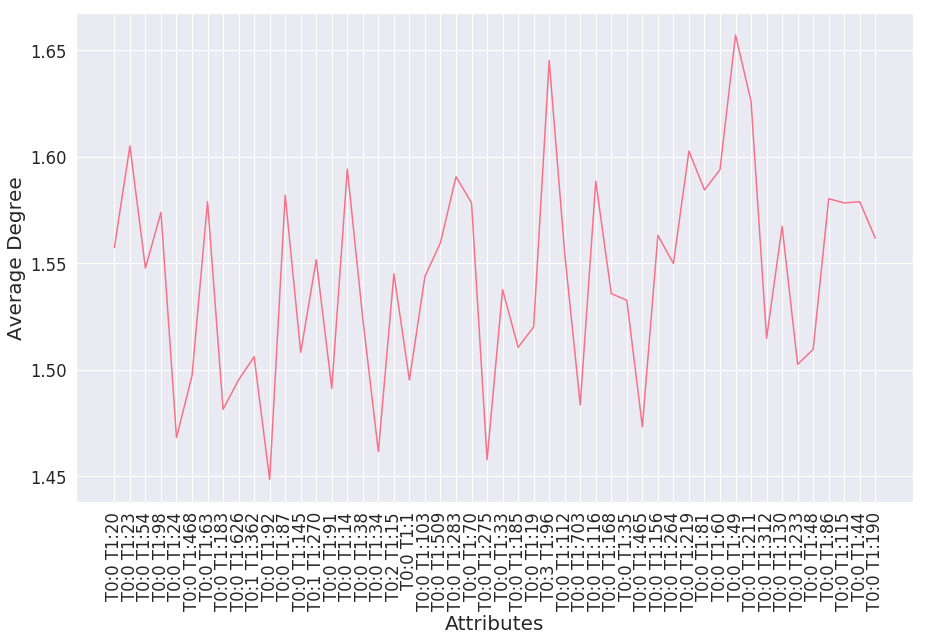

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Prepare the data
ave_degree_data = pd.DataFrame.from_dict({'Attributes':all_attributes, 'Ave_Degree': ave_degree_by_attribute})

# Set the style of seaborn plot
sns.set(style='darkgrid', palette='husl', font_scale=1.5)

# Create matplotlib Figure and Axes object
f, ax = plt.subplots(figsize=(15,9))

# Create the plot
g = sns.lineplot(x='Attributes', y='Ave_Degree', markers=True, data=ave_degree_data)

# Fine Tuning font size
g.set_xticklabels(ave_degree_data['Attributes'], rotation=90)
g.set_xlabel('Attributes', fontsize=20)
g.set_ylabel('Average Degree', fontsize=20)
# g.axes.set_title('Threshold to number of nodes', fontsize=30)

# Display
plt.show(g)

In [94]:
dev_results[dev_results['attr_y'] == 'T0:0 T1:20']

id           attr_x      attr_y     NE
5       1394998      T0:0 T1:653  T0:0 T1:20  False
19      1355779       T0:0 T1:20  T0:0 T1:20   True
100     3555383       T0:0 T1:20  T0:0 T1:20   True
116     3723758      T0:0 T1:374  T0:0 T1:20  False
255     1174040       T0:0 T1:20  T0:0 T1:20   True
286     1980144       T0:0 T1:20  T0:0 T1:20   True
360      516735       T0:0 T1:20  T0:0 T1:20   True
403      946185      T0:1 T1:270  T0:0 T1:20  False
405     5436988       T0:0 T1:98  T0:0 T1:20  False
448     1299069       T0:0 T1:38  T0:0 T1:20  False
549     4837047       T0:0 T1:92  T0:0 T1:20  False
678     3820865       T0:0 T1:20  T0:0 T1:20   True
684     5750939       T0:0 T1:54  T0:0 T1:20  False
691     3572557       T0:0 T1:20  T0:0 T1:20   True
712     4292224       T0:0 T1:20  T0:0 T1:20   True
780     3330279       T0:0 T1:92  T0:0 T1:20  False
815     5130099       T0:0 T1:20  T0:0 T1:20   True
834     3621526       T0:0 T1:20  T0:0 T1:20   True
864     1508753       T0:0 T1:60  T0:0 T1:20  False
913     6104136       T0:0 T1:20  T0:0 T1:20   True
982     2330561       T0:0 T1:23  T0:0 T1:20  False
996     2060557       T0:0 T1:20  T0:0 T1:20   True
1010     648701       T0:0 T1:20  T0:0 T1:20   True
1049    6366368      T0:0 T1:633  T0:0 T1:20  False
1065    1145544       T0:0 T1:20  T0:0 T1:20   True
1104     627178      T0:0 T1:524  T0:0 T1:20  False
1172    3685700  T0:0 T1:20 T8:1  T0:0 T1:20  False
1206    5108293       T0:0 T1:20  T0:0 T1:20   True
1380     962879      T0:0 T1:275  T0:0 T1:20  False
1442    5409083      T0:0 T1:219  T0:0 T1:20  False
...         ...              ...         ...    ...
660819  2194370       T0:0 T1:20  T0:0 T1:20   True
660853  4151025       T0:0 T1:20  T0:0 T1:20   True
660967  3369495       T0:0 T1:20  T0:0 T1:20   True
660999  2419579       T0:0 T1:37  T0:0 T1:20  False
661083   492491      T0:0 T1:116  T0:0 T1:20  False
661172  5500367      T0:0 T1:437  T0:0 T1:20  False
661201  4376980       T0:0 T1:23  T0:0 T1:20  False
661338  1815877       T0:0 T1:23  T0:0 T1:20  False
661349  1140320       T0:0 T1:20  T0:0 T1:20   True
661351  6536073       T0:0 T1:20  T0:0 T1:20   True
661367   510244       T0:0 T1:20  T0:0 T1:20   True
661429  3730646      T0:0 T1:275  T0:0 T1:20  False
661552  1673356       T0:0 T1:20  T0:0 T1:20   True
661596  3613406       T0:0 T1:20  T0:0 T1:20   True
661611  4439602      T0:0 T1:509  T0:0 T1:20  False
661612  4635708       T0:0 T1:20  T0:0 T1:20   True
661676  3737097       T0:0 T1:79  T0:0 T1:20  False
661703  5563190       T0:0 T1:20  T0:0 T1:20   True
661765  5370589       T0:0 T1:20  T0:0 T1:20   True
661779  1236179       T0:0 T1:20  T0:0 T1:20   True
661913   877764       T0:0 T1:20  T0:0 T1:20   True
661923  3498996       T0:0 T1:20  T0:0 T1:20   True
661952  6346403       T0:0 T1:34  T0:0 T1:20  False
662043  3711740      T0:0 T1:156  T0:0 T1:20  False
662085  6050431      T0:0 T1:116  T0:0 T1:20  False
662120  6342457       T0:0 T1:20  T0:0 T1:20   True
662133   640178       T0:0 T1:23  T0:0 T1:20  False
662163  3631032       T0:0 T1:20  T0:0 T1:20   True
662537  4956086       T0:0 T1:20  T0:0 T1:20   True
662606  3071112       T0:0 T1:20  T0:0 T1:20   True

[11393 rows x 4 columns]